In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Masking, LSTM, Dense
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [2]:
file_path = os.getenv('HOME') + '/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :', len(lines))
lines.sample(5) # 샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
148317,Are you being paid for doing this?,Est-ce que tu es payé pour faire ça ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
71534,I was going to use that.,J'allais utiliser cela.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
137556,I thought that we were partners.,Je pensais qu'on était partenaires.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
80719,I've rented an apartment.,J'ai loué un appartement.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
111056,You're starting to annoy me.,Vous commencez à m'ennuyer.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [3]:
lines = lines[['eng', 'fra']][:33000] # 
lines.sample(5)

,eng,fra
28615,This is expensive.,C'est cher.
7558,I feel queasy.,J'ai mal au cœur.
23413,Were you serious?,Étiez-vous sérieux ?
2626,We all die.,Nous mourons toutes.
3593,I'm winning.,Je l'emporte.


## 정제, 정규화, 전처리 & 디코더 문장에 시작 토큰과 종료 토큰 넣기.

In [4]:
def preprocessing(lines):
    e_input = lines.eng.apply(lambda x: re.sub(r"([?!.,])", r" \1", x.lower())).apply(lambda x: x.split())
    d_input = lines.fra.apply(lambda x: re.sub(r"([?!.,])", r" \1", x.lower())).apply(lambda x: ("<sos> " + x).split())
    d_target = lines.fra.apply(lambda x: re.sub(r"([?!.,])", r" \1", x.lower())).apply(lambda x: (x + " <eos>").split())
    
    return e_input, d_input, d_target

In [5]:
e_input, d_input, d_target = preprocessing(lines)

In [6]:
e_input

0                            [go, .]
1                            [go, .]
2                            [go, .]
3                            [go, .]
4                            [hi, .]
                    ...             
32995    [i, want, to, meet, tom, .]
32996    [i, want, to, see, more, .]
32997    [i, want, to, see, that, .]
32998    [i, want, to, see, them, .]
32999    [i, want, to, see, this, .]
Name: eng, Length: 33000, dtype: object

In [7]:
d_input

0                                   [<sos>, va, !]
1                               [<sos>, marche, .]
2                            [<sos>, en, route, !]
3                                [<sos>, bouge, !]
4                                [<sos>, salut, !]
                           ...                    
32995              [<sos>, je, veux, voir, tom, .]
32996    [<sos>, je, veux, en, voir, davantage, .]
32997               [<sos>, je, veux, voir, ça, .]
32998              [<sos>, je, veux, les, voir, .]
32999             [<sos>, je, veux, voir, ceci, .]
Name: fra, Length: 33000, dtype: object

In [8]:
d_target

0                                   [va, !, <eos>]
1                               [marche, ., <eos>]
2                            [en, route, !, <eos>]
3                                [bouge, !, <eos>]
4                                [salut, !, <eos>]
                           ...                    
32995              [je, veux, voir, tom, ., <eos>]
32996    [je, veux, en, voir, davantage, ., <eos>]
32997               [je, veux, voir, ça, ., <eos>]
32998              [je, veux, les, voir, ., <eos>]
32999             [je, veux, voir, ceci, ., <eos>]
Name: fra, Length: 33000, dtype: object

## 케라스의 토크나이저로 텍스트를 숫자로 바꾸기

In [9]:
eng_tokenizer = Tokenizer(filters="", lower=False)
eng_tokenizer.fit_on_texts(e_input)
encoder_input = eng_tokenizer.texts_to_sequences(e_input)
encoder_input = pad_sequences(encoder_input, padding='post')

In [10]:
encoder_input[:3]

array([[24,  1,  0,  0,  0,  0,  0],
       [24,  1,  0,  0,  0,  0,  0],
       [24,  1,  0,  0,  0,  0,  0]], dtype=int32)

In [11]:
fra_tokenizer = Tokenizer(filters="", lower=False)
fra_tokenizer.fit_on_texts(d_input)
fra_tokenizer.fit_on_texts(d_target)

decoder_input = fra_tokenizer.texts_to_sequences(d_input)
decoder_input = pad_sequences(decoder_input, padding='post')

decoder_target = fra_tokenizer.texts_to_sequences(d_target)
decoder_target = pad_sequences(decoder_target, padding='post')

In [12]:
encoder_input.shape, decoder_input.shape, decoder_target.shape

((33000, 7), (33000, 14), (33000, 14))

In [13]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어 집합의 크기 :', eng_vocab_size)
print('프랑스 단어 집합의 크기 :', fra_vocab_size)

영어 단어 집합의 크기 : 4648
프랑스 단어 집합의 크기 : 9720


In [14]:
eng_to_index = eng_tokenizer.word_index
index_to_eng = eng_tokenizer.index_word
fra_to_index = fra_tokenizer.word_index
index_to_fra = fra_tokenizer.index_word

In [15]:
shuffle = np.arange(encoder_input.shape[0])
np.random.shuffle(shuffle)
print('랜덤 시퀀스 :', shuffle)

랜덤 시퀀스 : [22089  4295 23975 ... 23462 29577  4027]


In [16]:
encoder_input = encoder_input[shuffle]
decoder_input = decoder_input[shuffle]
decoder_target = decoder_target[shuffle]

In [17]:
encoder_input[2023]

array([  9,  30, 981,   1,   0,   0,   0], dtype=int32)

decoder input 데이터와 target 데이터가 같은지 확인.

In [18]:
decoder_input[2023]

array([  2,   4, 177,  16,   8, 977,   1,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

In [19]:
decoder_target[2023]

array([  4, 177,  16,   8, 977,   1,   3,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

In [20]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [21]:
print("훈련 데이터 크기 :", encoder_input_train.shape, decoder_input_train.shape, decoder_target_train.shape)

훈련 데이터 크기 : (30000, 7) (30000, 14) (30000, 14)


In [22]:
print("테스트 데이터 크기 :", encoder_input_test.shape, decoder_input_test.shape, decoder_target_test.shape)

테스트 데이터 크기 : (3000, 7) (3000, 14) (3000, 14)


## 임베딩 층(Embedding layer) 사용하기

In [23]:
embedding_dim = 64
hidden_units = 64

In [24]:
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [25]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(fra_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True.
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어를 예측
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델 구현하기

In [26]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit(x=[encoder_input_train, decoder_input_train], 
          y=decoder_target_train, validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 17s 37ms/step - loss: 3.5981 - accuracy: 0.5923 - val_loss: 2.1917 - val_accuracy: 0.6028
Epoch 2/50
235/235 [==============================] - 7s 28ms/step - loss: 2.0206 - accuracy: 0.6732 - val_loss: 1.8940 - val_accuracy: 0.7347
Epoch 3/50
235/235 [==============================] - 7s 28ms/step - loss: 1.7982 - accuracy: 0.7374 - val_loss: 1.7297 - val_accuracy: 0.7413
Epoch 4/50
235/235 [==============================] - 7s 28ms/step - loss: 1.6553 - accuracy: 0.7451 - val_loss: 1.6173 - val_accuracy: 0.7507
Epoch 5/50
235/235 [==============================] - 7s 28ms/step - loss: 1.5466 - accuracy: 0.7593 - val_loss: 1.5246 - val_accuracy: 0.7681
Epoch 6/50
235/235 [==============================] - 7s 28ms/step - loss: 1.4494 - accuracy: 0.7755 - val_loss: 1.4413 - val_accuracy: 0.7831
Epoch 7/50
235/235 [==============================] - 7s 28ms/step - loss: 1.3583 - accuracy: 0.7896 - val_loss: 1.3626 - val_accuracy: 0.795

<function matplotlib.pyplot.show(close=None, block=None)>

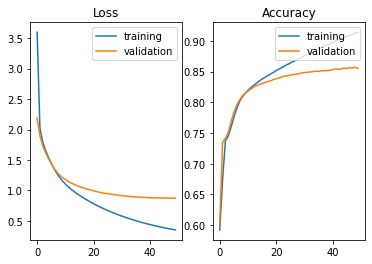

In [28]:
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc='upper right')
plt.title('Loss')
plt.show

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper right')
plt.title('Accuracy')
plt.show

### 테스트 과정을 위해 모델을 재설계

In [29]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코터
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units))
decoder_state_input_c = Input(shape=(hidden_units))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예츨을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측.
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)

## 모델 평가하기

In [30]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    states_value = encoder_model.predict(input_seq)
    
    # <sos>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra_to_index['<sos>']
    
    stop_condition = False
    decoded_sentence = ''
    
    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정.
    while not stop_condition:
        # 이전 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_fra[sampled_token_index]
        
        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char
        
        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or len(decoded_sentence) > 50):
            stop_condition = True
        
        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]
        
    return decoded_sentence

In [31]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_eng(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if (encoded_word != 0):
            sentence = sentence + index_to_eng[encoded_word] + ' '
    
    return sentence

In [32]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_fra(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if (encoded_word != 0 and encoded_word != fra_to_index['<sos>'] and encoded_word != fra_to_index['<eos>']):
            sentence = sentence + index_to_fra[encoded_word] + ' '
    
    return sentence

#### training data

In [33]:
for seq_index in [3, 50, 100, 300, 1001]:
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    print("입력문장 :", seq_to_eng(encoder_input_train[seq_index]))
    print("정답문장 :", seq_to_fra(decoder_input_train[seq_index]))
    print("번역문장 :", decoded_sentence[1:-5])
    print("-"*40)

입력문장 : you're skinny . 
정답문장 : vous êtes maigrichons . 
번역문장 : vous êtes maigrichonne . 
----------------------------------------
입력문장 : i couldn't do that . 
정답문장 : je n'ai pas pu faire cela . 
번역문장 : je ne pouvais pas le faire . 
----------------------------------------
입력문장 : stay in bed . 
정답문장 : restez alités ! 
번역문장 : reste au lit ! 
----------------------------------------
입력문장 : keep driving . 
정답문장 : continuez à rouler ! 
번역문장 : continuez à rouler ! 
----------------------------------------
입력문장 : everybody sat down . 
정답문장 : tout le monde s'assit . 
번역문장 : tout le monde s'assit . 
----------------------------------------


#### 1번 문장  
you're skinny . : 말랐군요  
vous êtes maigrichons . : 당신은 날씬해 보입니다.  
vous êtes maigrichonne . : 당신은 날씬해 보입니다.  

training data의 1번 문장은 잘 매칭되었습니다.

#### 2번 문장
i couldn't do that . : 나는 그렇게 할 수 없었어요.  
je n'ai pas pu faire cela . : 그럴 수가 없었다  
je ne pouvais pas le faire . : 저는 할 수 없었습니다.  

2번 문장도 비슷하게 잘 매칭되었습니다.

#### 3번 문장

stay in bed . : 누워있어요  
restez alités ! : 계속 누워 계세요!

reste au lit ! : 침대에 있어!  

3번 문장도 의미는 비슷하게 잘 매칭되었습니다.

#### 4번 문장 

keep driving . : 운전을 계속하다.  
continuez à rouler ! : 계속 운전하세요!  

continuez à rouler ! : 계속 운전하세요!  

4번 문장은 똑같이 나왔습니다.

#### 5번 문장

everybody sat down . : 모두 자리에 앉았습니다.  
tout le monde s'assit . : 모두들 앉습니다.  
tout le monde s'assit . : 모두들 앉습니다.  

5번 문장도 똑같이 나왔습니다.

#### test data

In [34]:
for seq_index in [3, 50, 100, 300, 1001]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    print("입력문장 :", seq_to_eng(encoder_input_test[seq_index]))
    print("정답문장 :", seq_to_fra(decoder_input_test[seq_index]))
    print("번역문장 :", decoded_sentence[1:-5])
    print("-"*40)

입력문장 : it's sweet . 
정답문장 : c'est mignon . 
번역문장 : c'est bizarre . 
----------------------------------------
입력문장 : i'm not wealthy . 
정답문장 : je ne suis pas riche . 
번역문장 : je ne suis pas riche . 
----------------------------------------
입력문장 : we'll hurry . 
정답문장 : nous nous dépêcherons . 
번역문장 : nous vous avez gagné ! 
----------------------------------------
입력문장 : i love bread . 
정답문장 : j'adore le pain . 
번역문장 : j'adore le pain . 
----------------------------------------
입력문장 : i can't say . 
정답문장 : je ne peux le dire . 
번역문장 : je ne peux pas le dire . 
----------------------------------------


#### 1번 문장

it's sweet . : 달콤해요.  
c'est mignon . : 귀엽다.  
c'est bizarre . : 참 이상한 일이다  

1번 문장은 번역이 잘 안된것 같네요.

#### 2번 문장

i'm not wealthy . : 저는 부유하지 않습니다.  
je ne suis pas riche . : 저는 부자가 아니에요.  
je ne suis pas riche . : 저는 부자가 아니에요.  

2번 문장은 잘 번역되었습니다!

#### 3번 문장

we'll hurry . : 서두르겠습니다.  
nous nous dépêcherons .  : 서두르겠습니다  
nous vous avez gagné ! : 우리가 이겼어!  

3번 문장은 전혀 맞지 않네요

#### 4번 문장

i love bread . : 저는 빵을 좋아합니다.  
j'adore le pain . : 저는 빵을 좋아합니다.  
j'adore le pain . : 저는 빵을 좋아합니다.  

4번 문장은 잘 번역되었습니다.

#### 5번 문장

i can't say . : 글쎄, 잘 모르겠는걸요.  
je ne peux le dire . : 나는 그 말을 할 수 없다  
je ne peux pas le dire . : 나는 그 말을 할 수 없다  

5번 문장은 문장에 pas? 라는 단어가 들어갔지만 뜻은 같다는것 같습니다.

# 회고

* 번역은 파파고의 힘을 빌렸습니다.
* 번역의 정확도와 모델의 정확도는 어떤 관계가 있는 것일까요? 정확도는 80~90% 대인데 결과물은 그렇지 않은것 같습니다.
    출력되는 단어들 중 정답과 같은 단어들이 나오는 정도에 관련이 있는것일까요? 
* 번역이 생각보다 잘되는 것 같아서 신기했습니다, 잘맞는 것은 잘 되는데 아닌건 전혀 아닌것같으니 데이터의 수가 부족했던것 같습니다.


## 참고자료

https://wikidocs.net/86900  
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html